In [1]:
import random as r
import numpy as np
import math as m
import matplotlib.pyplot as plt
import networkx as nx
import mynetworkx as my_nx
import matplotlib.animation as ani
import copy 

__Single neuron algorithm__

In [2]:
def growingneuron(angle_lower_bound,angle_upperbound,T,lambd,initial_position):
    start_pos = np.array(initial_position)
    direction = r.uniform(angle_lower_bound,angle_upperbound)
    growing_axons =[[start_pos,direction,0]]
    t=0;
    edges =[]
    while t<T:
        tau = np.random.exponential(1/(lambd*len(growing_axons)))
        t+=tau
        axon_index = r.randint(0,len(growing_axons)-1)
        axon = growing_axons[axon_index]
        new_pos=axon[0]+np.array([(t-axon[2])*m.cos(axon[1]),(t-axon[2])*m.sin(axon[1])])
        edge =[axon[0],new_pos]
        edges.append(edge)        
        x_values=[axon[0][0],new_pos[0]]
        y_values=[axon[0][1],new_pos[1]]
        plt.plot(x_values,y_values,'k',linewidth=0.4)
        
        new_direction1 = r.uniform(angle_lower_bound,angle_upperbound)+axon[1]
        new_direction2 = r.uniform(angle_lower_bound,angle_upperbound)+axon[1]
        growing_axons.pop(axon_index)
        growing_axons.append([new_pos,new_direction1,t])
        growing_axons.append([new_pos,new_direction2,t])
    
    for axon in growing_axons:
        if axon[2]<T:
            new_pos=axon[0]+np.array([(T-axon[2])*m.cos(axon[1]),(T-axon[2])*m.sin(axon[1])])
            edge = [axon[0],new_pos]
            edges.append(edge)
            x_values=[axon[0][0],new_pos[0]]
            y_values=[axon[0][1],new_pos[1]]
            plt.plot(x_values,y_values,'k',linewidth=0.4)
    return(edges)


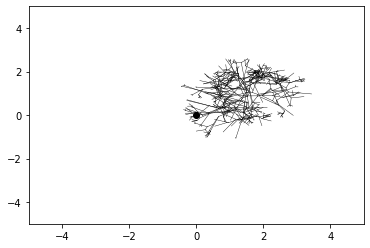

In [34]:
plt.xlim(right=5,left=-5)
plt.ylim(top=5,bottom=-5)
plt.scatter(0,0,color="black")
edges =growingneuron(-m.pi/2,m.pi/2,4,2,[0,0])
#plt.savefig('singleneuron2.png', bbox_inches='tight')

_Network Tools_

In [3]:
def dist_point_to_segment(P2,P1,P):
    u = ((P[0]-P1[0])*(P2[0]-P1[0])+(P[1]-P1[1])*(P2[1]-P1[1]))/(m.sqrt((P2[0]-P1[0])**2 + (P2[1]-P1[1])**2))
    if u > 1:
        u = 1
    elif u < 0:
        u = 0
    x = P1[0]+u*(P2[0]-P1[0])
    y = P1[1]+u*(P2[1]-P1[1])
    return (m.sqrt((x-P[0])**2 + (y-P[1])**2))
    
def dist_tree_to_vtx(tree_edges,v):
    d=1000
    for edge in tree_edges:
        u = dist_point_to_segment(edge[0],edge[1],v)
        if u<d:
            d=u
    return(d)

def are_vtx_connected(edges_tree_for_v,w,radius):
    dist = dist_tree_to_vtx(edges_tree_for_v,w)
    if dist<=radius:
        return(True)
    else:
        return(False)
        

_Generating soma_

In [19]:
#Generating random soma in the space [-x,x]x[-y,y]
def generateSoma(mu,x_range,y_range):
    mu=0.4
    x_range =[-5,5]
    y_range =[-5,5]

    area = (y_range[1]-y_range[0])*(x_range[1]-x_range[0])
    numberOfSoma = np.random.poisson(mu*area)

    #Distributing the soma randomly in space
    x_pos=np.random.uniform(x_range[0],x_range[1],numberOfSoma)
    y_pos=np.random.uniform(y_range[0],y_range[1],numberOfSoma)
    soma =[]
    for i in range(0,numberOfSoma):
        soma.append([x_pos[i],y_pos[i]])
    return([soma,x_pos,y_pos])


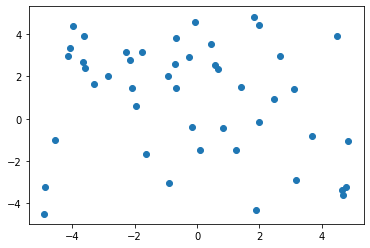

In [6]:
somaPositions = generateSoma(0.4,[-5,5],[-5,5])
plt.scatter(somaPositions[1],somaPositions[2])
plt.savefig('generatesoma.png', bbox_inches='tight')

__Full network growth model__

In [8]:
def growRandomNetwork(mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,lamb,radius):
    soma = generateSoma(mu,x_range,y_range)
    plt.scatter(soma[1],soma[2])
    trees =[]
    somaPositions = soma[0]
    for v in somaPositions:
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,v)
        trees.append(edges)

    adjacencyMatrix =[]

    for v in somaPositions:
        v_connections =[]
        for tree in trees:
            if are_vtx_connected(tree,v,radius):
                v_connections.append(1)
            else:
                v_connections.append(0)
        adjacencyMatrix.append(v_connections)

    for i in range(0,len(somaPositions)):
        #remove self connections
        adjacencyMatrix[i][i]=0
    #transpose the matrix (as we built the transpose)
    adjacencyMatrix = np.array(adjacencyMatrix).T.tolist()
    return([adjacencyMatrix,soma])

In [ ]:
Network = growRandomNetwork(0.4,[-5,5],[-5,5],-m.pi,m.pi,4,1,1)
plt.savefig('grownnetwork.png', bbox_inches='tight')

__Graph tools for ordinary network__

In [24]:
#Graph tools
def makeGraph(Network):
    adj = Network[0]
    nodeInfo = Network[1]
    N=len(adj)
    G = nx.DiGraph()
    for i in range(0,N):
        G.add_node(i,pos=(nodeInfo[1][i],nodeInfo[2][i]))
        for j in range(0,N): 
                if adj[i][j] == 1: 
                    G.add_edge(i,j)
    return(G)

def plotGraph(G):
    nx.draw(G,nx.get_node_attributes(G, 'pos'),with_labels=False)

def circlePlotGraph(G):
    nx.draw_circular(G)
    plt.savefig('HN.png', bbox_inches='tight')
    plt.show()

def averageDegree(G):
    K = 0
    for node in G.nodes():
        K+=G.degree(node)
    return(K/G.number_of_nodes())

def basicAnalysisGraph(G):
    print("Nodes: " + str(G.number_of_nodes()))
    print("Edges: " + str(G.number_of_edges()))
    print("Average degree: " + str(averageDegree(G)))

def plotDegreeDistribution(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.show()

Nodes: 29
Edges: 143
Average degree: 9.862068965517242


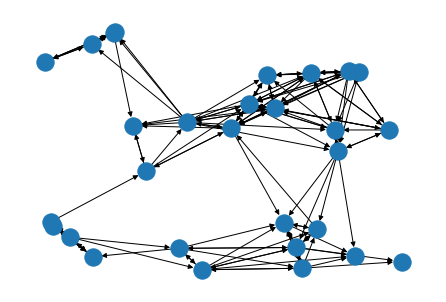

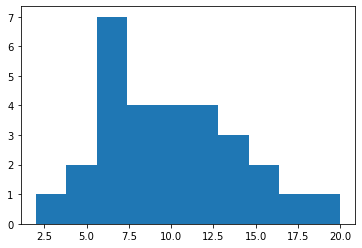

In [23]:
G=makeGraph(Network)
basicAnalysisGraph(G)
plotGraph(G)
plt.savefig('Network.png', bbox_inches='tight')
plt.show()
plotDegreeDistribution(G)

__Hyper graphical structures__

__EI Networks__

_EI Soma Generation_

In [17]:
#Generating random soma in the space [-x,x]x[-y,y]
def generateEISoma(mu,x_range,y_range,EIprop):
    area = (y_range[1]-y_range[0])*(x_range[1]-x_range[0])
    numberOfSoma = np.random.poisson(mu*area)
    #Distributing the soma randomly in space
    x_pos=np.random.uniform(x_range[0],x_range[1],numberOfSoma)
    y_pos=np.random.uniform(y_range[0],y_range[1],numberOfSoma)
    soma =[]
    for i in range(0,numberOfSoma):
        EI=np.random.uniform(0,1)
        if EI>EIprop:
            EItype="E"
        else:
            EItype="I"
        soma.append([x_pos[i],y_pos[i],EItype])
    return([soma,x_pos,y_pos])
mu=0.4
x_range =[-5,5]
y_range =[-5,5]

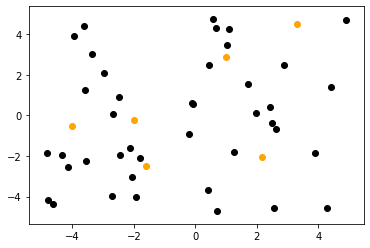

In [13]:
somaPositions = generateEISoma(0.4,[-5,5],[-5,5],0.2)
xpos=somaPositions[1]
ypos=somaPositions[2]
soma=somaPositions[0]
for i in range(0,len(xpos)):
    if soma[i][2]=="I":
        plt.scatter(xpos[i],ypos[i],color="orange")
    else:
        plt.scatter(xpos[i],ypos[i],color="black")

__EI Network Model__

In [10]:
def growRandomEINetwork(mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,lamb,radius,EIprop):
    soma = generateEISoma(mu,x_range,y_range,EIprop)
    xpos=soma[1]
    ypos=soma[2]
    somaInfo=soma[0]
    for i in range(0,len(xpos)):
        if somaInfo[i][2]=="I":
            plt.scatter(xpos[i],ypos[i],color="orange")
        else:
            plt.scatter(xpos[i],ypos[i],color="black")

    trees =[]
    somaPositions = soma[0]
    for v in somaPositions:
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,v[:2])
        trees.append(edges)

    adjacencyMatrix =[]

    for v in somaPositions:
        v_connections =[]
        for tree in trees:
            if are_vtx_connected(tree,v,radius):
                v_connections.append(1)
            else:
                v_connections.append(0)
        adjacencyMatrix.append(v_connections)

    for i in range(0,len(somaPositions)):
        #remove self connections
        adjacencyMatrix[i][i]=0
    #transpose the matrix (as we built the transpose)
    adjacencyMatrix = np.array(adjacencyMatrix).T.tolist()
    return([adjacencyMatrix,somaPositions])

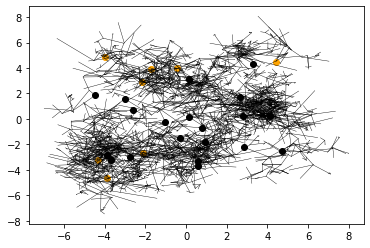

In [18]:
EInetwork = growRandomEINetwork(0.4,[-5,5],[-5,5],-m.pi,m.pi,4,1,1,0.2)
plt.savefig('grownEinetwork.png', bbox_inches='tight')

_Graph tools for EI Networks_

In [31]:
def starExpansion(EINetwork):
    adjMatrix = copy.deepcopy(EINetwork[0])
    somaPositions = EINetwork[1]
    for j in range(0,len(somaPositions)):
        if somaPositions[j][2]=="E":
            adjMatrix[j].append(1)
            adjMatrix[j].append(0)
        else:
            adjMatrix[j].append(0)
            adjMatrix[j].append(1)            
    adjMatrix.append([0] * (len(somaPositions)+2))
    adjMatrix.append([0] * (len(somaPositions)+2))
    return(adjMatrix)

def makeColourHyperGraph(Network):
    adj = Network[0]
    nodeInfo = Network[1]
    colour_map =[]
    G = nx.DiGraph() 
    for i in range(0,len(nodeInfo)):
        G.add_node(i,pos=(nodeInfo[i][0],nodeInfo[i][1]))
        if nodeInfo[i][2]=="I":
            colour_map.append("orange")
        else:
            colour_map.append("black")
        for j in range(0,len(nodeInfo)): 
            if adj[i][j] == 1: 
                G.add_edge(i,j)
    return([G,colour_map])

def plotColourGraph(G,colour_map):
    nx.draw(G,nx.get_node_attributes(G, 'pos'),node_color=colour_map, with_labels=False)
    plt.savefig('EInetwork.png', bbox_inches='tight')
    plt.show()
    
def plotStarGraph(adj):
    #Graph tools
    N=len(adj)
    G = nx.DiGraph()
    for i in range(0,N):
        for j in range(0,N): 
            if adj[i][j] == 1: 
                G.add_edge(i,j)
    N = G.number_of_nodes()
    color_map = []
    for node in G:
        if node == N-1:
            color_map.append("orange")
        elif node == N-2:
            color_map.append("black")
        else:
            color_map.append("blue")
    nx.draw_networkx(G,node_color = color_map,pos = nx.drawing.layout.bipartite_layout(G, [N-2,N-1]),with_labels = False)  
    return(G)

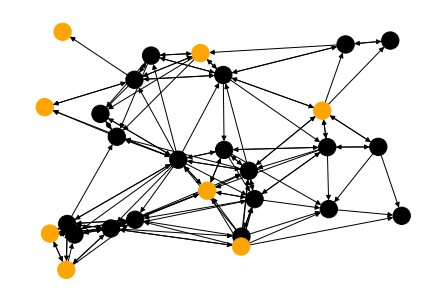

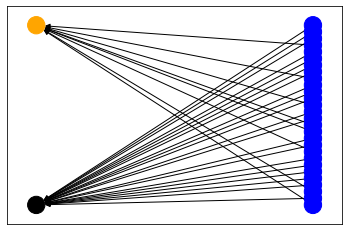

In [21]:
starMatrix = starExpansion(EInetwork)
colourGraph=makeColourHyperGraph(EInetwork)
plotColourGraph(colourGraph[0],colourGraph[1])
starGraph = plotStarGraph(starMatrix)

_EI Network Analysis_

In [12]:
def EIGraphNumberOfNodes(G):
    N=G.number_of_nodes()
    print("Nodes: " + str(N))
    print("Neurons: " + str(N-2))
    print("Excitory: " + str(G.degree(N-2)))
    print("Inhibitory: " + str(G.degree(N-1)))

def calculateEIDegreeDistribution(Network):
    inh_degrees = []
    exc_degrees = []
    adj = Network[0]
    G=makeColourHyperGraph(Network)[0]
    nodeInfo = Network[1]
    for i in range(0,len(nodeInfo)):
        if nodeInfo[i][2]=="I":
            inh_degrees.append(G.degree(i))
        else:
            exc_degrees.append(G.degree(i))
    return([inh_degrees,exc_degrees])

def plotEIDegreeDistribution(inh_degrees,exc_degrees):
    plt.hist(inh_degrees, alpha =0.7,label="Inhibitory",color="orange")
    plt.hist(exc_degrees,alpha=0.5, label="Excitory",color ="grey")
    plt.legend(loc='upper right')
    plt.show()

Nodes: 33
Neurons: 31
Excitory: 29
Inhibitory: 2


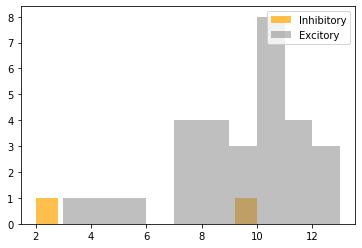

In [17]:
EIGraphNumberOfNodes(starGraph)
degrees = calculateEIDegreeDistribution(EInetwork)
plotEIDegreeDistribution(degrees[0],degrees[1])

__Clustered growth: Local/Projection Networks__

_Loc-Proj Soma_

In [13]:
#Generating random soma in the space [-x,x]x[-y,y]

def generateLocProjSoma(inter_mu,proj_mu,x_range,y_range):
    area = (y_range[1]-y_range[0])*(x_range[1]-x_range[0])
    numberOfInterSoma = np.random.poisson(inter_mu*area)
    numberOfProjSoma = np.random.poisson(proj_mu*area)
    #Distributing the soma randomly in space
    inter_x_pos=list(np.random.uniform(x_range[0],x_range[1],numberOfInterSoma))
    inter_y_pos=list(np.random.uniform(y_range[0],y_range[1],numberOfInterSoma))
    proj_x_pos=list(np.random.uniform(x_range[0],x_range[1],numberOfProjSoma))
    proj_y_pos=list(np.random.uniform(y_range[0],y_range[1],numberOfProjSoma))
    x_pos=np.array(inter_x_pos+proj_x_pos)
    y_pos=np.array(inter_y_pos+proj_y_pos)
    soma =[]
    for i in range(0,numberOfInterSoma):
        soma.append([inter_x_pos[i],inter_y_pos[i],"Inter"])
    for i in range(0,numberOfProjSoma):
        soma.append([proj_x_pos[i],proj_y_pos[i],"Proj"])
    return([soma,x_pos,y_pos])

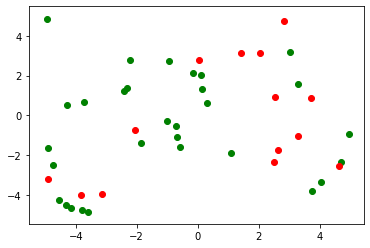

In [22]:
somaPositions = generateLocProjSoma(0.4,0.1,[-5,5],[-5,5])
xpos=somaPositions[1]
ypos=somaPositions[2]
soma=somaPositions[0]
for i in range(0,len(xpos)):
    if soma[i][2]=="Inter":
        plt.scatter(xpos[i],ypos[i],color="green")
    else:
        plt.scatter(xpos[i],ypos[i],color="red")

_Organisation into clusters_

In [14]:
def generateClusteredLocProjSoma(inter_mu,proj_mu,x_range,y_range):
    x_dist = x_range[1]-x_range[0]
    y_dist = y_range[1]-y_range[0]
    clusters =[]
    clusters.append(generateLocProjSoma(inter_mu,proj_mu,[x_range[0],x_range[0]+x_dist/3],[y_range[1]-y_dist/3,y_range[1]]))
    clusters.append(generateLocProjSoma(inter_mu,proj_mu,[x_range[1]-x_dist/3,x_range[1]],[y_range[1]-y_dist/3,y_range[1]]))
    clusters.append(generateLocProjSoma(inter_mu,proj_mu,[x_range[0]+x_dist/3,x_range[1]-x_dist/3],[y_range[0]+y_dist/3,y_range[1]-y_dist/3]))
    clusters.append(generateLocProjSoma(inter_mu,proj_mu,[x_range[0],x_range[0]+x_dist/3],[y_range[0],y_range[0]+y_dist/3]))
    clusters.append(generateLocProjSoma(inter_mu,proj_mu,[x_range[1]-x_dist/3,x_range[1]],[y_range[0],y_range[0]+y_dist/3]))
    return(clusters)

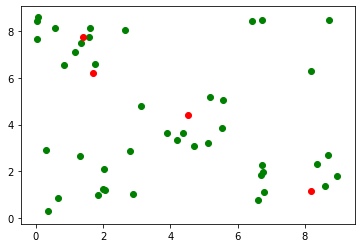

In [36]:
clusters = generateClusteredLocProjSoma(1,0.2,[0,9],[0,9])
for c in clusters:
    xpos=c[1]
    ypos=c[2]
    soma=c[0]
    for i in range(0,len(xpos)):
        if soma[i][2]=="Inter":
            plt.scatter(xpos[i],ypos[i],color="green")
        else:
            plt.scatter(xpos[i],ypos[i],color="red")
plt.savefig('Clusteredsoma.png', bbox_inches='tight')


__Clustered Loc-Proj Network Model__

In [15]:
def growRandomClusteredLocProjNetwork(inter_mu,proj_mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,inter_lamb,proj_lamb,radius):
    clusters = generateClusteredLocProjSoma(inter_mu,proj_mu,x_range,y_range)
    loctrees =[]
    projtrees=[]
    trees=[]
    for c in clusters:
        xpos=c[1]
        ypos=c[2]
        soma=c[0]
        for i in range(0,len(xpos)):
            if soma[i][2]=="Inter":
                plt.scatter(xpos[i],ypos[i],color="green")
                edges=growingneuron(angle_lowerbound,angle_upperbound,T,inter_lamb,[xpos[i],ypos[i]])
                loctrees.append(edges)
            else:
                plt.scatter(xpos[i],ypos[i],color="red")
                edges=growingneuron(angle_lowerbound,angle_upperbound,T,proj_lamb,[xpos[i],ypos[i]])
                projtrees.append(edges)
            trees.append(edges)

    adjacencyMatrix =[]
    somaPos=[]
    for c in clusters:
        somaPositions = c[0]
        for s in somaPositions:
            s.append(clusters.index(c)+1)
        somaPos.extend(somaPositions)
        for v in somaPositions:
            v_connections =[]
            for tree in trees:
                if are_vtx_connected(tree,v,radius):
                    v_connections.append(1)
                else:
                    v_connections.append(0)
            adjacencyMatrix.append(v_connections)

    for i in range(0,len(adjacencyMatrix)):
        #remove self connections
        adjacencyMatrix[i][i]=0
    #transpose the matrix (as we built the transpose)
    adjacencyMatrix = np.array(adjacencyMatrix).T.tolist()
    return([adjacencyMatrix,somaPos])

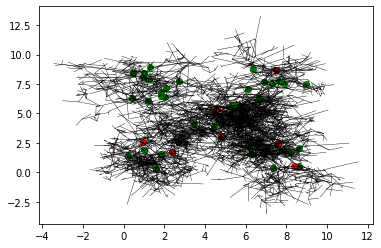

In [112]:
LocProjNetwork = growRandomClusteredLocProjNetwork(1,0.2,[0,9],[0,9],-m.pi,m.pi,4,1,0.5,1)
plt.savefig('grownclusterednetwork.png', bbox_inches='tight')

_Graph tools for the clustered network_

In [111]:
def areClustersConnected(i,j,Network):
    adj=Network[0]
    nodeInfo=Network[1]
    for n in range(0,len(nodeInfo)):
        if nodeInfo[n][3]==i:
            for m in range(0,len(adj)):
                if adj[n][m]==1:
                    if nodeInfo[m][3]==j:
                        return(True)
    return(False)

def countClusterConnections(i,j,Network):
    adj=Network[0]
    nodeInfo=Network[1]
    c=0
    for n in range(0,len(nodeInfo)):
        if nodeInfo[n][3]==i:
            for m in range(0,len(adj)):
                if adj[n][m]==1:
                    if nodeInfo[m][3]==j:
                        c+=1
    return(c)

def ClusterGraph(Network):
    adj=Network[0]
    nodeInfo=Network[1]
    n = nodeInfo[len(nodeInfo)-1][3]
    clusterAdj =[]
    for i in range(1,n+1):
        clusterConnections=[]
        for j in range(1,n+1):
            if areClustersConnected(i,j,Network):
                clusterConnections.append(1)
            else:
                clusterConnections.append(0)
        clusterAdj.append(clusterConnections)
    #Remove self connections
    for i in range(0,n):
        clusterAdj[i][i]=0
    return(clusterAdj)

def WeightedClusterGraph(Network):
    adj=Network[0]
    nodeInfo=Network[1]
    n = nodeInfo[len(nodeInfo)-1][3]
    clusterAdj =[]
    for i in range(1,n+1):
        clusterConnections=[]
        for j in range(1,n+1):
            clusterConnections.append(countClusterConnections(i,j,Network))
        clusterAdj.append(clusterConnections)
    #Remove self connections
    for i in range(0,n):
        clusterAdj[i][i]=0
    return(clusterAdj)

def makeClusterGraph(adj):
    G = nx.DiGraph()
    G.add_node(1, pos=(1, 3))
    G.add_node(2, pos=(3, 3))
    G.add_node(3, pos=(2, 2))
    G.add_node(4, pos=(1, 1))
    G.add_node(5, pos=(3, 1))
    for i in range(0,len(adj)):
        for j in range(0,len(adj)):
            if adj[i][j]==1:
                G.add_edge(i+1,j+1)
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True, node_size=1000)
    plt.show()
    return(G)

def makeWeightedClusterGraph(adj):
    G = nx.DiGraph()
    G.add_node(1, pos=(1, 3))
    G.add_node(2, pos=(3, 3))
    G.add_node(3, pos=(2, 2))
    G.add_node(4, pos=(1, 1))
    G.add_node(5, pos=(3, 1))
    for i in range(0,len(adj)):
        for j in range(0,len(adj)):
            if adj[i][j]>0:
                G.add_edge(i+1,j+1,weight=adj[i][j])
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos)
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, edgelist=straight_edges)
    arc_rad = 0.1
    nx.draw_networkx_edges(G, pos, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
    edge_weights = nx.get_edge_attributes(G,'weight')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=straight_edge_labels,rotate=False)
    plt.savefig('weightedclustergraph.png', bbox_inches='tight')
    plt.show()
    return(G)

def makeColourHyperGraphLocProj(Network):
    adj = Network[0]
    nodeInfo = Network[1]
    colour_map =[]
    G = nx.DiGraph()
    for i in range(0,len(nodeInfo)):
        G.add_node(i,pos=(nodeInfo[i][0],nodeInfo[i][1]))
        if nodeInfo[i][2]=="Inter":
            colour_map.append("green")
        else:
            colour_map.append("red")
        for j in range(0,len(nodeInfo)): 
            if adj[i][j] == 1: 
                G.add_edge(i,j)
    return([G,colour_map])

def plotColourGraph(G,colour_map):
    nx.draw(G,nx.get_node_attributes(G, 'pos'),node_color=colour_map, with_labels=False)
    plt.savefig('clusterenetwork.png', bbox_inches='tight')
    plt.show()

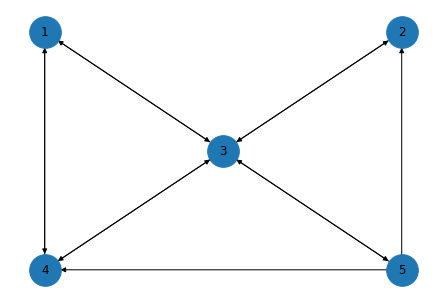

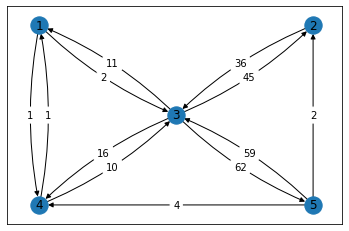

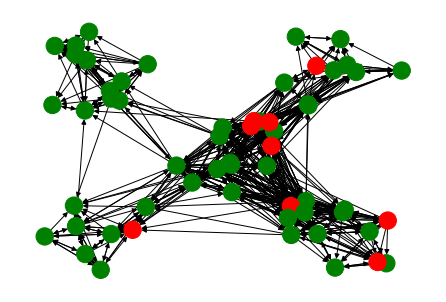

In [113]:
CG =ClusterGraph(LocProjNetwork)
WCG=WeightedClusterGraph(LocProjNetwork)
PCG=makeClusterGraph(CG)
PWCG=makeWeightedClusterGraph(WCG)
G = makeColourHyperGraphLocProj(LocProjNetwork)
plotColourGraph(G[0],G[1])

In [71]:
print(np.array(WCG))

[[ 0  4 12  0  0]
 [ 0  0 13  0  0]
 [ 7  7  0  4  4]
 [ 0  0  7  0  3]
 [ 0  0  1  2  0]]


_Graph analysis tools for Loc-Proj network_

In [23]:
def LocProjGraphNumberOfNodes(Network):
    nodeInfo=Network[1]
    proj=0
    inter=0
    print("Neurons: " + str(len(nodeInfo)))
    for i in range(0,len(nodeInfo)):
        if nodeInfo[i][2]=="Inter":
            inter+=1
        else:
            proj+=1
    print("Projectory Neurons: "+ str(proj))
    print("Interneurons: " + str (inter))

def calculateLocProjDegreeDistribution(Network):
    loc_degrees = []
    proj_degrees = []
    adj = Network[0]
    G=makeColourHyperGraphLocProj(Network)[0]
    nodeInfo = Network[1]
    for i in range(0,len(nodeInfo)):
        if nodeInfo[i][2]=="Inter":
            loc_degrees.append(G.degree(i))
        else:
            proj_degrees.append(G.degree(i))
    return([loc_degrees,proj_degrees])

def plotLocProjDegreeDistribution(loc_degrees,proj_degrees):
    plt.hist(loc_degrees, alpha =0.7,label="Interneurons",color="green")
    plt.hist(proj_degrees,alpha=0.5, label="Projectory Neurons",color ="red")
    plt.xlabel("Degree")
    plt.ylabel("Frequency density")
    plt.legend(loc='upper right')
    plt.show()

Neurons: 58
Projectory Neurons: 9
Interneurons: 49


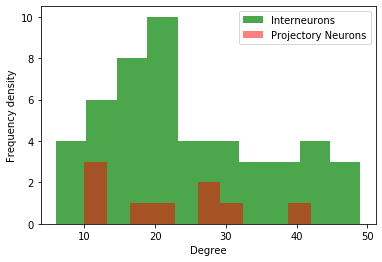

In [114]:
LocProjGraphNumberOfNodes(LocProjNetwork)
degrees = calculateLocProjDegreeDistribution(LocProjNetwork)
plotLocProjDegreeDistribution(degrees[0],degrees[1])

_Detailed analysis_

In [25]:
def calculateProjectoryDegree(Network):
    adj = Network[0]
    nodeInfo= Network[1]
    degrees = [0]*len(nodeInfo)
    for i in range(0,len(nodeInfo)):
        for j in range(0,len(nodeInfo)):
            if adj[i][j]==1:
                if nodeInfo[j][3]!=nodeInfo[i][3]:
                    degrees[i]+=1
    return(degrees)

def calculateLocProjProjectoryDegreeDistribution(Network,degrees):
    loc_degrees = []
    proj_degrees = []
    adj = Network[0]
    G=makeColourHyperGraphLocProj(Network)[0]
    nodeInfo = Network[1]
    for i in range(0,len(nodeInfo)):
        if nodeInfo[i][2]=="Inter":
            loc_degrees.append(degrees[i])
        else:
            proj_degrees.append(degrees[i])
    return([loc_degrees,proj_degrees])

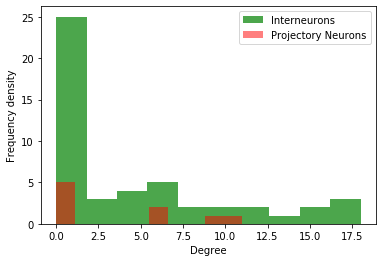

In [115]:
projectoryDegrees=calculateProjectoryDegree(LocProjNetwork)
degrees=calculateLocProjProjectoryDegreeDistribution(LocProjNetwork,projectoryDegrees)
plotLocProjDegreeDistribution(degrees[0],degrees[1])

__Growing a layered neural network for machine learning__

In [11]:
def distributeFirstLayer(soma,inputLayer):
    input_x_pos=list(np.random.uniform(0,2,inputLayer))
    input_y_pos=list(np.random.uniform(0,8,inputLayer))
    for i in range(0,inputLayer):
        soma.append([input_x_pos[i],input_y_pos[i],1])
    return(soma)

def distributeOutputLayer(soma,outputLayer,noLayers):
    output_x_pos=list(np.random.uniform(2*(noLayers-1),2*noLayers,outputLayer))
    output_y_pos=list(np.random.uniform(0,8,outputLayer))
    for i in range(0,outputLayer):
        soma.append([output_x_pos[i],output_y_pos[i],noLayers])
    return(soma)

def distributeHiddenLayers(soma,mu,noLayers):
    for i in range(1,noLayers-1):
        no_nodes = np.random.poisson(mu*16)
        x_pos=list(np.random.uniform(2*i,2*(i+1),no_nodes))
        y_pos=list(np.random.uniform(0,8,no_nodes))
        for j in range(0,no_nodes):
            soma.append([x_pos[j],y_pos[j],i+1])
    return(soma)

In [119]:
def growRandomLayeredNetwork(mu,inputLayer,outputLayer,noLayers,angle_lowerbound,angle_upperbound,T,lamb,radius):
    soma = distributeFirstLayer([],inputLayer)
    soma = distributeOutputLayer(soma,outputLayer,noLayers)
    soma = distributeHiddenLayers(soma,mu,noLayers)
    trees=[]
    for i in range(0,len(soma)):
        plt.scatter(soma[i][0],soma[i][1],color="black")
        plt.savefig('layeredsoma.png', bbox_inches='tight')
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,[soma[i][0],soma[i][1]])
        trees.append(edges)
    adjMatrix =[]
    for i in range(0,len(soma)):
        connections =[]
        v=[soma[i][0],soma[i][1]]
        for j in range(0,len(trees)):
            if are_vtx_connected(trees[j],v,radius):
                if soma[j][2]==soma[i][2]-1:
                    connections.append(1)
                else:
                    connections.append(0)
            else:
                connections.append(0)
        adjMatrix.append(connections)
    
    #For the output layer which has no connections
    for i in range(0,len(adjMatrix)):
        #remove self connections
        adjMatrix[i][i]=0
    #transpose the matrix (as we built the transpose)
    adjMatrix = np.array(adjMatrix).T.tolist()
    return([adjMatrix,soma])
    

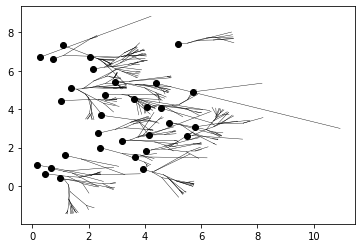

In [146]:
LayeredNetwork = growRandomLayeredNetwork(1,10,10,3,-m.pi/6,m.pi/6,2,1,1)
plt.savefig('layeredgrownnetwork.png', bbox_inches='tight')

_Displaying Layered Network Model_

In [10]:
def calculateNumberOfLayers(Network):
    n=0
    for node in Network[1]:
        if node[2]>n:
            n=node[2]
    return(n)

def organiseLayers(Network):
    adj = Network[0]
    noLayers = calculateNumberOfLayers(Network)
    nodeInfo = Network[1]
    G = nx.DiGraph()
    Layers = [[] for x in range(noLayers)]
    for i in range(0,len(nodeInfo)):
        Layers[nodeInfo[i][2]-1].append(nodeInfo[i])
    return(Layers)

def sortLayersByYPos(layers):
    sortedLayers=[]
    for layer in layers:
        sortedLayers.append(sorted(layer, key = lambda x: x[1]))
    return(sortedLayers)

def makeLayeredGraph(Network):
    adj=Network[0]
    nodeInfo=Network[1]
    layers = sortLayersByYPos(organiseLayers(Network))
    G = nx.DiGraph()
    for i in range(0,len(nodeInfo)):
        node = nodeInfo[i]
        layer = layers[node[2]-1]
        positionInLayer = layer.index(node)
        G.add_node(i,pos=(2*(node[2]),2*positionInLayer))
        for j in range(0,len(nodeInfo)):
            if adj[i][j]==1:
                G.add_edge(i,j)
    return(G)
        
def plotLayeredGraph(G):
    nx.draw(G,nx.get_node_attributes(G, 'pos'), with_labels=False)
    plt.savefig('TNN1.png', bbox_inches='tight')
    plt.show()       

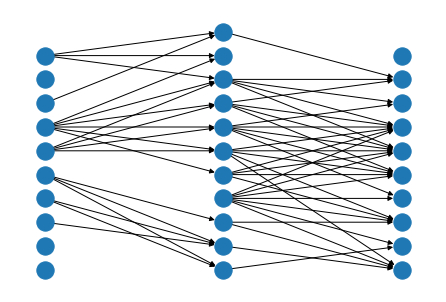

In [147]:
G=makeLayeredGraph(LayeredNetwork)
plotLayeredGraph(G)

_EI Layered Network_

In [13]:
def distributeEI(soma,EIprop):
    for i in range(0,len(soma)):
        EI=np.random.uniform(0,1)
        if EI>EIprop:
            EItype="E"
        else:
            EItype="I"
        soma[i].append(EItype)
    return(soma)

def makeColourMap(somaInfo):
    colour_map =[]
    for soma in somaInfo:
        if soma[3] == "E":
            colour_map.append("black")
        else:
            colour_map.append("orange")
    return(colour_map)

def plotColouredLayeredGraph(G,colour_map):
    nx.draw(G,nx.get_node_attributes(G, 'pos'),node_color =colour_map, with_labels=False)
    plt.savefig('EINN.png', bbox_inches='tight')
    plt.show()   

In [7]:
def growRandomEILayeredNetwork(mu,inputLayer,outputLayer,noLayers,angle_lowerbound,angle_upperbound,T,lamb,radius,EIprop):
    soma = distributeFirstLayer([],inputLayer)
    soma = distributeOutputLayer(soma,outputLayer,noLayers)
    soma = distributeHiddenLayers(soma,mu,noLayers)
    soma = distributeEI(soma,EIprop)
    trees=[]
    for i in range(0,len(soma)):
        if soma[i][3]=="E":
            plt.scatter(soma[i][0],soma[i][1],color="black")
        else:
            plt.scatter(soma[i][0],soma[i][1],color="orange")
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,[soma[i][0],soma[i][1]])
        trees.append(edges)
    adjMatrix =[]
    for i in range(0,len(soma)):
        connections =[]
        v=[soma[i][0],soma[i][1]]
        for j in range(0,len(trees)):
            if are_vtx_connected(trees[j],v,radius):
                if soma[j][2]==soma[i][2]-1:
                    connections.append(1)
                else:
                    connections.append(0)
            else:
                connections.append(0)
        adjMatrix.append(connections)
    
    #For the output layer which has no connections
    for i in range(0,len(adjMatrix)):
        #remove self connections
        adjMatrix[i][i]=0
    #transpose the matrix (as we built the transpose)
    adjMatrix = np.array(adjMatrix).T.tolist()
    return([adjMatrix,soma])

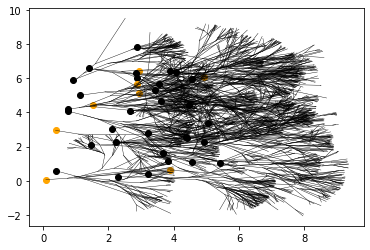

In [12]:
EILayeredNetwork = growRandomEILayeredNetwork(1,10,10,3,-m.pi/6,m.pi/6,4,1,1,0.2)
plt.savefig('EIGNN.png', bbox_inches='tight')

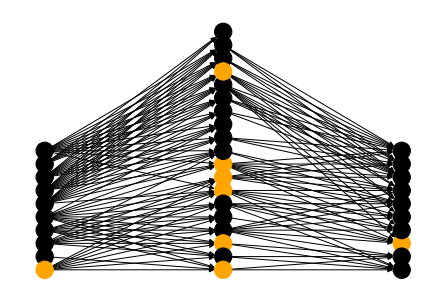

In [14]:
G = makeLayeredGraph(EILayeredNetwork)
CM = makeColourMap(EILayeredNetwork[1])
plotColouredLayeredGraph(G,CM)

In [132]:
def findDisconnectedNodes(Network):
    noLayers = calculateNumberOfLayers(Network)
    adj=Network[0]
    nodeInfo=Network[1]
    unconnectedNodes =[]
    for i in range(0,len(nodeInfo)):
        connected = False
        if nodeInfo[i][2]==noLayers or nodeInfo[i][2]==1: #Do not remove output or input layers
            connected = True
        for j in range(0,len(nodeInfo)):
            if adj[i][j]==1:
                connected = True
        if not connected:
            unconnectedNodes.append(i)
    return(unconnectedNodes)

def removeDisconnectedNodes(Network):
    unconnectedNodes=sorted(findDisconnectedNodes(Network))
    adj=Network[0]
    nodeInfo=Network[1]
    for i in range(0,len(unconnectedNodes)):
        adj = np.delete(adj,unconnectedNodes[i]-i,axis=1)
        adj = np.delete(adj,unconnectedNodes[i]-i,axis=0)
        nodeInfo.pop(unconnectedNodes[i]-i)
    return([adj,nodeInfo])

In [134]:
removeDisconnectedNodes(LayeredNetwork)

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 [[1.1275515933680225, 2.7089930795294705, 1],
  [1.2823519932901988, 1.3368937632764188, 1],
  [0.7368780187474055, 1.7130988602551618, 1],
  [0.5057990555884737, 5.148361035494081, 1],
  [1.7766712107812297, 3.5673404925323524, 1],
  [1.1729361210786433, 7.393064961945128, 1],
  [1.899412519365838, 5.532087771083612, 1],
  [1.4326650851812603, 5.671396221536592, 1],
  [0.4220869842092163, 2.748315662719423, 1],
  [0.15956023800371777, 2.1051075513720514, 1],
  [5.987933504003099, 0.12550591854086335, 3],
  [4.873302935211452, 5.499715405892624, 3],
  [4.355776212032736, 4.709162472357648, 3],
  [5.922994526394753, 3.1288010177188976, 3],
  [4.395273402387911, 2.642102305555259, 3],
  [5.87820293042425, 2.400911477836127, 3],
  [4.196195951134946, 2.5895407002675777, 3],
  [5

In [127]:
def findUnusedNodes(Network):
    noLayers = calculateNumberOfLayers(Network)
    adj=Network[0]
    nodeInfo=Network[1]
    unusedNodes =[]
    for i in range(0,len(nodeInfo)):
        used = False
        if nodeInfo[i][2]==noLayers or nodeInfo[i][2]==1: #Do not remove output or input layers
            used = True
        for j in range(0,len(nodeInfo)):
            if adj[j][i]==1:
                used = True
        if not used:
            unusedNodes.append(i)
    return(unusedNodes)

def removeUnusedNodes(Network):
    unusedNodes=sorted(findUnusedNodes(Network))
    adj=Network[0]
    nodeInfo=Network[1]
    for i in range(0,len(unusedNodes)):
        adj = np.delete(adj,unusedNodes[i]-i,axis=1)
        adj = np.delete(adj,unusedNodes[i]-i,axis=0)
        nodeInfo.pop(unusedNodes[i]-i)
    return([adj,nodeInfo])

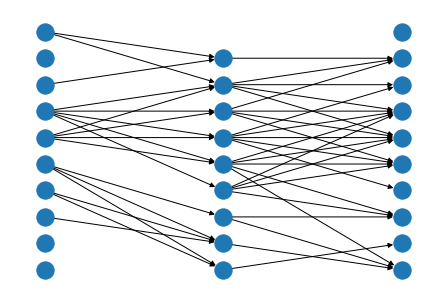

In [149]:
G=makeLayeredGraph(removeUnusedNodes(removeDisconnectedNodes(LayeredNetwork)))
plotLayeredGraph(G)

__Hopfield Networks__

In [20]:
def growRandomHopfieldNetwork(mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,lamb,radius):
    soma = generateSoma(mu,x_range,y_range)
    plt.scatter(soma[1],soma[2])
    trees =[]
    somaPositions = soma[0]
    N = len(somaPositions)
    for v in somaPositions:
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,v)
        trees.append(edges)

    adjacencyMatrix = np.zeros(shape=(N,N))

    for i in range(0,N):
        for j in range(0,N):
            if adjacencyMatrix[i][j]==0:
                if are_vtx_connected(trees[j],somaPositions[i],radius):
                    adjacencyMatrix[i][j]=1
                    adjacencyMatrix[j][i]=1

    for i in range(0,N):
        #remove self connections
        adjacencyMatrix[i][i]=0
    adjacencyMatrix = adjacencyMatrix.tolist()
    return([adjacencyMatrix,soma])

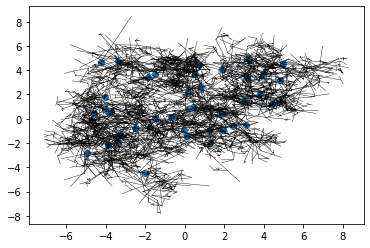

In [23]:
HopfieldNetwork = growRandomHopfieldNetwork(0.4,[-5,5],[-5,5],-m.pi,m.pi,4,1,1)
plt.savefig('GHN.png', bbox_inches='tight')

Nodes: 43
Edges: 544
Average degree: 25.302325581395348


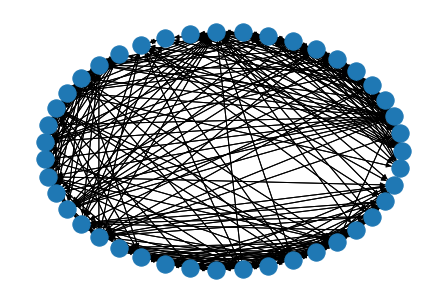

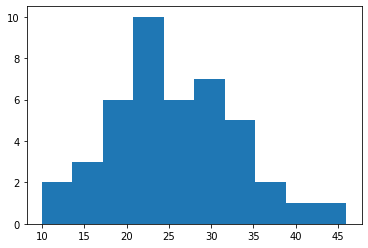

In [25]:
G=makeGraph(HopfieldNetwork)
basicAnalysisGraph(G)
circlePlotGraph(G)
plotDegreeDistribution(G)

In [78]:
def isMatrixSymmetric(adj):
    return adj == np.array(adj).T.tolist()
isMatrixSymmetric(HopfieldNetwork[0])

True

In [26]:
def growRandomEIHopfieldNetwork(mu,x_range,y_range,angle_lowerbound,angle_upperbound,T,lamb,radius,EIprop):
    soma = generateEISoma(mu,x_range,y_range,EIprop)
    xpos=soma[1]
    ypos=soma[2]
    somaInfo=soma[0]
    for i in range(0,len(xpos)):
        if somaInfo[i][2]=="I":
            plt.scatter(xpos[i],ypos[i],color="orange")
        else:
            plt.scatter(xpos[i],ypos[i],color="black")

    trees =[]
    somaPositions = soma[0]
    N = len(somaPositions)

    for v in somaPositions:
        edges=growingneuron(angle_lowerbound,angle_upperbound,T,lamb,v[:2])
        trees.append(edges)

    adjacencyMatrix = np.zeros(shape=(N,N))

    for i in range(0,N):
        for j in range(0,N):
            if adjacencyMatrix[i][j]==0:
                if are_vtx_connected(trees[j],somaPositions[i],radius):
                    adjacencyMatrix[i][j]=1
                    adjacencyMatrix[j][i]=1
                    
    for i in range(0,len(somaPositions)):
        #remove self connections
        adjacencyMatrix[i][i]=0
    adjacencyMatrix = adjacencyMatrix.tolist()
    return([adjacencyMatrix,somaPositions])

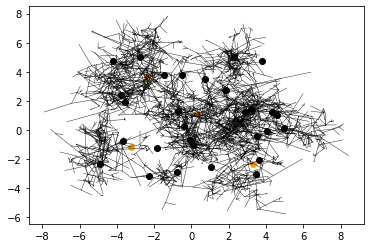

In [29]:
EIHopfieldNetwork = growRandomEIHopfieldNetwork(0.4,[-5,5],[-5,5],-m.pi,m.pi,4,1,1,0.2)
plt.savefig('EIGHN.png', bbox_inches='tight')

_Graph tools for EI Hopfield_

In [28]:
def circlePlotColourGraph(G,colour_map):
    nx.draw_circular(G,node_color=colour_map, with_labels=False)
    plt.savefig('EIHN.png', bbox_inches='tight')
    plt.show()

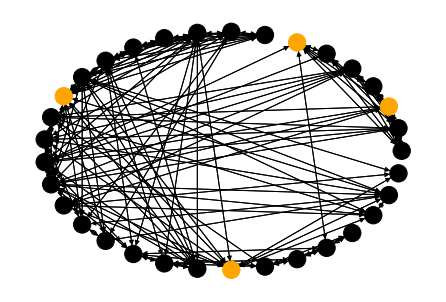

In [32]:
HyperGraph = makeColourHyperGraph(EIHopfieldNetwork)
circlePlotColourGraph(HyperGraph[0],HyperGraph[1])

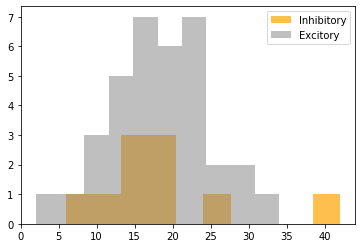

In [92]:
degrees = calculateEIDegreeDistribution(EIHopfieldNetwork)
plotEIDegreeDistribution(degrees[0],degrees[1])